In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# set random seed value for reproducable results
seed_value= 4815
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

print(f"torch version: {torch.__version__}")
print(torch.cuda.get_device_name(0))

torch version: 1.13.1+cu117
NVIDIA GeForce RTX 3060 Ti


In [2]:
EPOCHS = 50
BATCH_SIZE_TRAIN = 64
VALIDATION = True

# load data

In [3]:
data_path = "data/"
train_path = data_path + "train2014/train2014"
val_path = data_path + "val2014/val2014"

with open(os.path.join(train_path +"_processed.pickle"), "rb") as f:
    training_data = pickle.load(f)
len_training_data_raw = len(training_data)

training_data = training_data[:len(training_data) // BATCH_SIZE_TRAIN * BATCH_SIZE_TRAIN]
print(f"number training data: {len(training_data)}")
print("batch_size_train: " + str(BATCH_SIZE_TRAIN))

if VALIDATION:
    with open(os.path.join(val_path + "_processed.pickle"), "rb") as f:
        validation_data = pickle.load(f)
    # batch_size_val = int(BATCH_SIZE_TRAIN * (len(validation_data) / (len_training_data_raw + len(validation_data))))
    batch_size_val = BATCH_SIZE_TRAIN
    validation_data = validation_data[:len(validation_data) // batch_size_val * batch_size_val]
    print(f"number validation data: {len(validation_data)}")
    print(f"batch_size_val: {batch_size_val}")

number training data: 78784
batch_size_train: 64
number validation data: 38528
batch_size_val: 64


In [4]:
class torch_dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, index):
        x = torch.from_numpy((self.data[index][0].astype(float) - 127.5) / 127.5)
        y = torch.from_numpy(self.data[index][1].astype(float).flatten())
        return x, y
    def __len__(self):
        return len(self.data)

training_dataset = torch_dataset(training_data)
if VALIDATION:
    validation_dataset = torch_dataset(validation_data)

# construct network

In [5]:
input_shape = (128, 128, 2)
kernel_size = 3
pool_size = 2
channels = 64
dropout = 0.5

class homography_net(nn.Module):
    def __init__(self):
        super(homography_net,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(input_shape[2], channels, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels),
                                    nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(channels, channels, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels),
                                    nn.ReLU(),
                                    nn.MaxPool2d(pool_size))

        self.layer3 = nn.Sequential(nn.Conv2d(channels, channels, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(channels, channels ,kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels),
                                    nn.ReLU(),
                                    nn.MaxPool2d(pool_size))

        self.layer5 = nn.Sequential(nn.Conv2d(channels, channels*2, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels*2),
                                    nn.ReLU())        
        self.layer6 = nn.Sequential(nn.Conv2d(channels*2, channels*2, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels*2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(pool_size))

        self.layer7 = nn.Sequential(nn.Conv2d(channels*2, channels*2, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels*2),
                                    nn.ReLU())
        self.layer8 = nn.Sequential(nn.Conv2d(channels*2, channels*2, kernel_size, padding='same'),
                                    nn.BatchNorm2d(channels*2),
                                    nn.ReLU())

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(128*16*16, 1024)
        self.fc2 = nn.Linear(1024, 8)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.flatten(out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [6]:
train_loader = torch.utils.data.DataLoader(training_dataset, BATCH_SIZE_TRAIN)
if VALIDATION:
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size_val)

num_samples = len(training_data)
steps_per_epoch = num_samples / BATCH_SIZE_TRAIN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = homography_net().to(device)
summary(model, (2, 128, 128))

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = nn.MSELoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,216
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

# train network

In [7]:
train_losses, val_losses = [], []

def train(epoch):
    model.train()
    train_loss = 0
    for i, (images, target) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        target = target.to(device)
        images = images.permute(0,3,1,2).float()
        target = target.float()
        outputs = model(images)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f"epoch: {epoch+1}/{EPOCHS}, MSE: {train_loss}")
    train_losses.append(train_loss)

def eval(epoch):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(validation_loader):
            images = images.to(device)
            target = target.to(device)
            images = images.permute(0,3,1,2).float()
            target = target.float()
            output = model(images)
            val_loss += F.mse_loss(output, target).item()

    val_loss /= len(validation_loader)
    print(f"epoch: {epoch+1}/{EPOCHS}, val MSE: {val_loss}")
    val_losses.append(val_loss)

In [8]:
for epoch in range(EPOCHS):
    train(epoch)
    if VALIDATION:
        eval(epoch)

model_path = "model"             
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
torch.save(model, os.path.join(model_path, "torch_model_" + current_time + '.pth'))

epoch: 1/50, MSE: 0.08481072961291485
epoch: 1/50, val MSE: 0.04397481109984095
epoch: 2/50, MSE: 0.040246871657893486
epoch: 2/50, val MSE: 0.028035710435793844
epoch: 3/50, MSE: 0.029213142645591453
epoch: 3/50, val MSE: 0.02212209029871958
epoch: 4/50, MSE: 0.024091466020559702
epoch: 4/50, val MSE: 0.019695217154944853
epoch: 5/50, MSE: 0.021125991209118858
epoch: 5/50, val MSE: 0.017259678750784692
epoch: 6/50, MSE: 0.0189305428653096
epoch: 6/50, val MSE: 0.016213452025777675
epoch: 7/50, MSE: 0.017396819160435617
epoch: 7/50, val MSE: 0.014603792044621864
epoch: 8/50, MSE: 0.01618922018135083
epoch: 8/50, val MSE: 0.014090924656816892
epoch: 9/50, MSE: 0.015060569562175281
epoch: 9/50, val MSE: 0.012743627296704984
epoch: 10/50, MSE: 0.014119658541996531
epoch: 10/50, val MSE: 0.012697619942180887
epoch: 11/50, MSE: 0.013267981445312403
epoch: 11/50, val MSE: 0.012102726055618586
epoch: 12/50, MSE: 0.012689365747374892
epoch: 12/50, val MSE: 0.011640751889854225
epoch: 13/50, MS

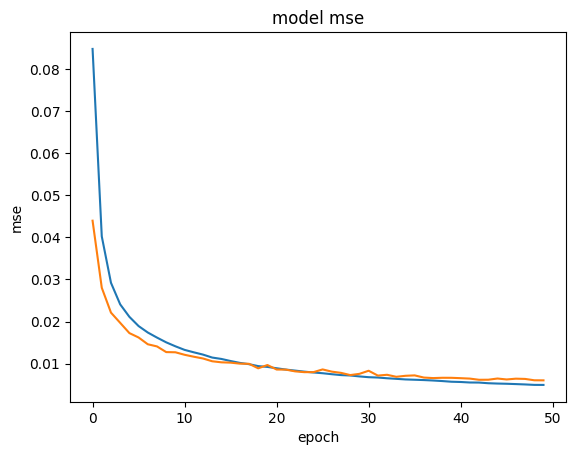

In [9]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()